In [1]:
using Plots
using LinearAlgebra
using Random
using Distributions

In [2]:
# Example data
Random.seed!(1234)  # determinism

# controlled-conditioning matrix
function rand_cond_mat(m::Int64, s::Float64)
    X = randn(m, 6)
    X[:, 3] = X[:, 1] + 3 * X[:, 2] + randn(m) / s
    X[:, 6] = X[:, 4] + 5 * X[:, 5] + randn(m) / s
    X = [X ones(m)]
    X ./= maximum(svdvals(X))  # Scale so that || X ||_2 = 1
    return X
end

# Get sample-feature matrices and linear systems
m = 100
scales = 10.0 .^ (1:7)
As = [rand_cond_mat(m, s) for s in scales]
r = 1e-1 * randn(m)
xtrue = randn(size(As[1], 2))
bs = [A * xtrue + r for A in As];

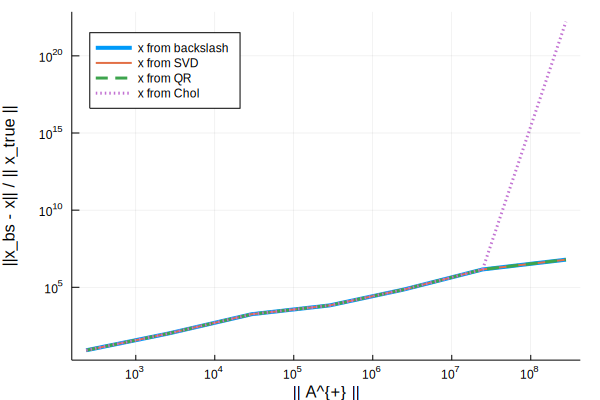

In [8]:
ls_bs(A::Array{Float64,2}, b::Vector{Float64}) = A \ b
function ls_chol(A::Array{Float64,2}, b::Vector{Float64})
    L = cholesky(A' * A, check=false).U'
    return L' \ (L \ (A' * b))
end
function ls_qr(A::Array{Float64,2}, b::Vector{Float64})
    Q, R = qr(A)
    return R \ (Matrix(Q)' * b)
end
function ls_svd(A::Array{Float64,2}, b::Vector{Float64})
    U, Σ, V = svd(A)
    return V * (Diagonal(Σ) \ (U' * b))
end

xhat_bs   = [ls_bs(  A, b) for (A, b) in zip(As, bs)]
xhat_chol = [ls_chol(A, b) for (A, b) in zip(As, bs)]
xhat_qr   = [ls_qr(  A, b) for (A, b) in zip(As, bs)]
xhat_svd  = [ls_svd( A, b) for (A, b) in zip(As, bs)]

ntrue = norm(xtrue)
bs_diff   = [norm(x - xtrue) / ntrue for x in xhat_bs]
chol_diff = [norm(x - xtrue) / ntrue for x in xhat_chol]
qr_diff   = [norm(x - xtrue) / ntrue for x in xhat_qr]
svd_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd]

conds = [opnorm(pinv(A),2) for A in As]

plot(conds,  bs_diff,   lw=4, 
     xlabel="|| A^{+} ||", ylabel="||x_bs - x|| / || x_true ||", 
     label="x from backslash", legend=:topleft)
plot!(conds, svd_diff,  lw=2, yscale=:log10, xscale=:log10, label="x from SVD")
plot!(conds, qr_diff,   lw=3, ls=:dash, label="x from QR")
plot!(conds, chol_diff, lw=3, ls=:dot,  label="x from Chol")